# Versuch 243 Thermisches Rauschen

### 1. Importieren der Messwerte

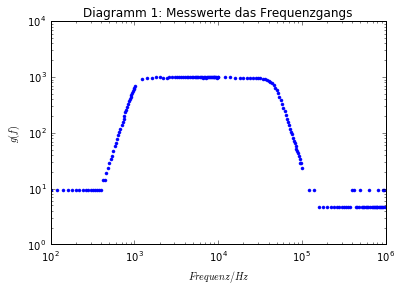

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
#import StringIO

#Falls Dezimaltrennzeichen Kommas, folgende Reihen benutzen:

#s = open('data/Messung.dat').read().replace(',','.')
#f, U_aus = np.loadtxt(StringIO.StringIO(s), skiprows=1, usecols=(0,1), unpack=True)

#Falls Dezimaltrennzeichen Punkte:

f, U_aus = np.loadtxt('Senghaas_Traub_Frequenzgang.txt', skiprows=1, usecols=(0,1), unpack=True)

D=1e-3
U_ein=0.21
g=U_aus/(U_ein * D)

plt.loglog(f,g,linestyle="None", marker=".")
#plt.axis([4E2, 1.5e5, 10, 1.5E3])
plt.xlabel(r'$Frequenz / Hz$')
plt.ylabel(r'$g(f)$')
plt.title("Diagramm 1: Messwerte das Frequenzgangs")
plt.ylim(1,10**4)
plt.savefig("Frequenzgang.pdf", orientation = 'landscape')

### 2. Curve-Fitting

Fit: V=984.7297912742082 +- 0.9031811883625965 W1=1029.8030664146909 +- 1.7227155406432264 W2=46363.66131554884 +- 77.80929883342834 n1=5.079920240418213 +- 0.045862317153338224 n2=4.648249921242465 +- 0.035195016787887834


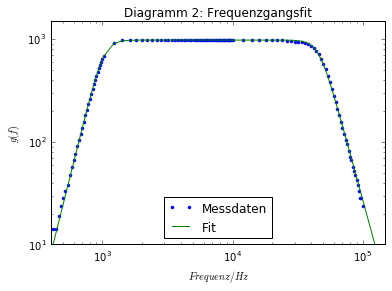

In [36]:
#Grenzen der Arrays f, g:
x=14
y=14

from scipy.optimize import curve_fit
def fit_func(f, V, W1, W2, n1, n2):
    return V/(np.sqrt(1+1/(f/W1)**(2*n1))*np.sqrt(1+(f/W2)**(2*n2)))

#Startwerte P0 für die Fitparameter:
#Verstärkung V: 1000
#untere Grenzfrequenz W1: 1000
#obere Grenzfrequenz W2: 50000
#Filterordnung n1, n2: 5

p0 = [1000, 1000, 50000, 5, 5]
popt, pcov = curve_fit(fit_func, f[x:-y], g[x:-y], p0)

plt.loglog(f[x:-y], g[x:-y], linestyle='None', marker='.', label='Messdaten')
plt.loglog(f, fit_func(f, *popt), label='Fit')
plt.axis([4E2, 1.5e5, 10, 1.5E3])
plt.xlabel(r'$Frequenz / Hz$')
plt.ylabel(r'$g(f)$')
plt.title("Diagramm 2: Frequenzgangsfit")
plt.legend(loc='best')
plt.savefig("Fit.pdf", orientation = 'landscape')

print('Fit: V={} +- {}'.format(popt[0],np.sqrt(pcov[0,0])), 'W1={} +- {}'.format(popt[1],np.sqrt(pcov[1,1])), 'W2={} +- {}'.format(popt[2],np.sqrt(pcov[2,2])), 'n1={} +- {}'.format(popt[3],np.sqrt(pcov[3,3])), 'n2={} +- {}'.format(popt[4],np.sqrt(pcov[4,4])))


### 3. Bestimmung von B (Integration)

In [37]:
import scipy.integrate as integrate

def fit_func_square(f,V,W1,W2,n1,n2):
    return fit_func(f,V,W1,W2,n1,n2)**2
B=integrate.quad(fit_func_square, f[x], f[-y], args=tuple(popt))

print('Das Integral beträgt: {value: .4e}'.format(value=B[0]))



Das Integral beträgt:  4.4811e+10


### 4. Bestimmung der Boltzmann-Konstante

chi^2 4.4228151603 
 chi_red^2:  0.88456303206
Wahrscheinlichkeit P = 49.0%


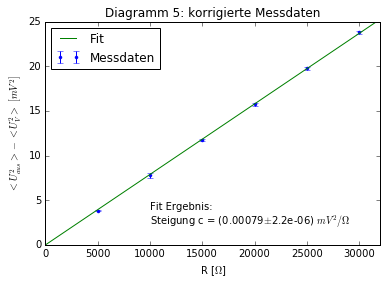

In [41]:
R=np.array([5000,10000,15000,20000,25000,30000])
U_aus=np.array([2.3953,3.1149,3.6935,4.2002,4.6555,5.0727])
fehler_U_aus=np.array([0.0104/np.sqrt(111),0.111/np.sqrt(101),0.0134/np.sqrt(105),0.0142/np.sqrt(99),0.0176/np.sqrt(101),0.0205/np.sqrt(99)]) #messungenauigkeit hier vernachlässigt!
U_V=1.3795
fehler_U_V=0.0055/10
D=U_aus**2-U_V**2
fehler_D=np.sqrt(2*U_aus*fehler_U_aus+2*U_V*fehler_U_V)

plt.errorbar(R, D, yerr=fehler_D, fmt='.', label='Messdaten')
plt.axis([0,3.2e4,0,25])
plt.xlabel('R [$\Omega$]')
plt.ylabel('$ <U_{aus}^2 > - <U_{V}^2>$ $[mV^2] $')
plt.title('Diagramm 5: korrigierte Messdaten')

def linear(x, c):
    return c*x
x = np.linspace(0,32000, 10000)
popt, pcov = curve_fit(linear, R, D)
plt.plot(x, linear(x, *popt), label='Fit')
plt.legend(loc='upper left')
plt.annotate('Fit Ergebnis: \nSteigung c = (' + str(round(popt[0], 5))+ '$  \pm $' + str(round(np.sqrt(pcov[0,0]), 7)) + ') $mV^2/ \Omega$', (10000, 2) )
plt.savefig("Boltzmannkonstante.pdf", orientation = 'landscape')

chisquare = np.sum(((linear(R,*popt)-D)**2/fehler_D**2))
dof= 5
chisquare_red=chisquare/dof
print('chi^2', chisquare, '\n', 'chi_red^2: ', chisquare_red)

from scipy.stats import chi2
prob=round(1-chi2.cdf(chisquare, dof),2)*100
print('Wahrscheinlichkeit P = ' + str(prob) + '%')

In [42]:
k_B = popt[0]/(4*(23.1+273.15)*B[0])*1e-06
print(k_B, 'J/K')
sys_fehler = k_B*np.sqrt((0.03/1)**2+(0.5/(23.1+273.15))**2) #Integrationsfehler?
print('sys: ', sys_fehler, 'J/K')
stat_fehler = k_B*np.sqrt(pcov[0,0])/popt[0]
print('stat: ', stat_fehler, 'J/K') 

1.48766133786e-23 J/K
sys:  4.47004122103e-25 J/K
stat:  4.20343747865e-26 J/K
